## cGAN convergence evaluation

Attempt-2

It seems to be working, so I'm putting much more compute time into it.

See generator details below.

In [85]:
# get data from storage 
! gsutil cp gs://gdax-dnn-tmp-1/cgan-statistics.pkl .
! gsutil cp gs://gdax-dnn-tmp-1/cgan-model.h5 .

Copying gs://gdax-dnn-tmp-1/cgan-statistics.pkl...
/ [1 files][ 34.0 KiB/ 34.0 KiB]                                                
Operation completed over 1 objects/34.0 KiB.                                     
Copying gs://gdax-dnn-tmp-1/cgan-model.h5...
/ [1 files][  6.7 MiB/  6.7 MiB]                                                
Operation completed over 1 objects/6.7 MiB.                                      


In [86]:
# missing dependencies 
import sys
! pip install --user tensorflow
! pip install --user keras
sys.path.append('/home/jupyter/.local/lib/python3.5/site-packages')

In [87]:
import pickle
with open('cgan-statistics.pkl', 'rb') as f:
    stats = pickle.load(f)

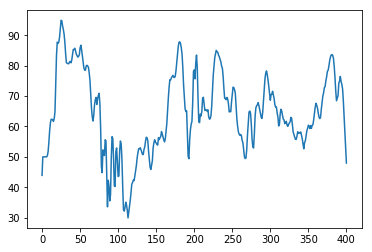

In [88]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_stat(stat):
    plt.plot(stats[stat])
    plt.show()
    pass

plot_stat('acc')

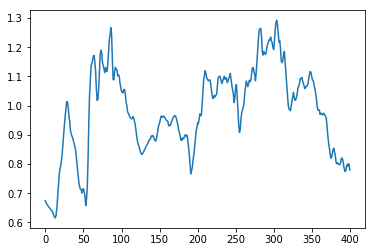

In [89]:
plot_stat('g_loss')

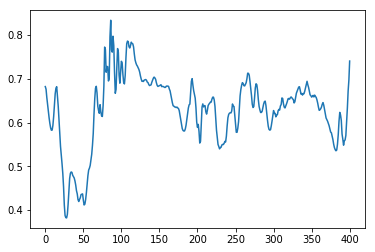

In [90]:
plot_stat('d_loss')

Convergence looks good. So, we'll finish this analysis with simulation histograms. 

In [91]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
import numpy as np

def build_generator(latent_dim=100, img_shape=(1024, 1), num_classes=3):
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape)))
    model.add(Reshape(img_shape))
    model.add(ReLU(negative_slope=0.2, threshold=0.))
    model.summary()
    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(num_classes, latent_dim)(label))
    model_input = multiply([noise, label_embedding])
    img = model(model_input)
    return Model([noise, label], img)

gen = build_generator()
gen.load_weights('cgan-model.h5')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 256)               1024      
_________________________________________________________________
dense_30 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 512)               2048      
_________________________________________________________________
dense_31 (Dense)             (None, 1024)             

In [92]:
def hist(x, num_bins=50, **kwargs):
    plt.hist(x, num_bins, **kwargs)
    plt.show()
    pass

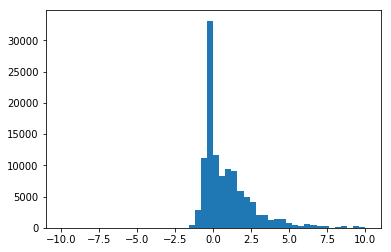

In [93]:
# Dead and not rewarded (0.4%)
y = gen.predict([np.random.normal(0, 1, (111, 100)), 0*np.ones(111)]).flatten()
hist(y,range=(-10,10))

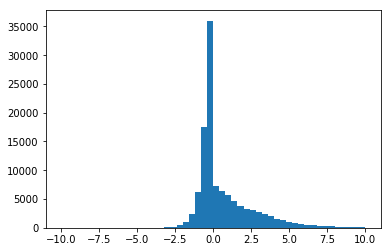

In [94]:
# Not dead and rewarded (3%)
y = gen.predict([np.random.normal(0, 1, (111, 100)), 1*np.ones(111)]).flatten()
hist(y,range=(-10,10))

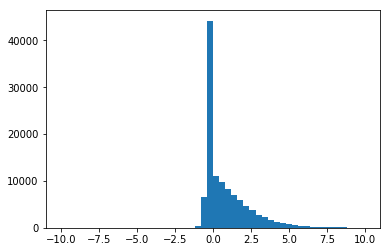

In [95]:
# Not dead and rewarded (96.6%)
y = gen.predict([np.random.normal(0, 1, (111, 100)), 2*np.ones(111)]).flatten()
hist(y,range=(-10,10))

In [81]:
! gsutil cp gs://gdax-dnn-tmp-1/cgan-data.pkl-backup .

Copying gs://gdax-dnn-tmp-1/cgan-data.pkl-backup...
/ [1 files][  1.5 GiB/  1.5 GiB]   23.7 MiB/s                                   
Operation completed over 1 objects/1.5 GiB.                                      


In [82]:
with open('cgan-data.pkl', 'rb') as f:
    cgan_data = pickle.load(f)

In [83]:
idx = np.random.choice(cgan_data[0].shape[0], 100)
x = cgan_data[0][idx,:] + 3.5

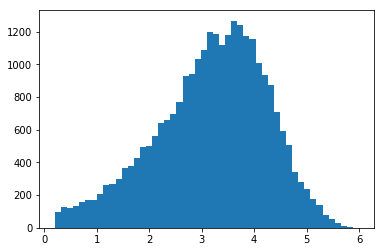

In [84]:
hist(x.flatten(), range=(.2, 6))

In [68]:
x += 3.5